# HRP
The main idea of HRP is to allocate weights to a portfolio of securities based on:

    -the clusters formed by securities (determined on how each security correlates to the portfolio)
    -the volatility of each cluster (more volatile clusters receive lesser weighting, and vice versa)
    
This post demonstrates a Rcpp + OpenMP implementation of the HRP methodology suggested by the paper. It uses security returns as input and churns out a weighting vector applies to all securities involved.

The computation is split into four stages:

    -Compute Distance Matrix
    -Clusterize Securities
    -Quasi-Diagonalize (QD) the Covariance Matrix
    -Generate Security Weighting
### Creamos un ejemplo de una matriz de correlaciones, y forzamos a que exista correlación en parte ella.

In [85]:
import numpy as np
import pandas as pd
import random

def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    return x,cols

In [110]:
x,cols = generateData(2000,10,10,0.25)
print(x)
print(cols)

            1         2         3         4         5         6         7   \
0    -0.204708  0.478943 -0.519439 -0.555730  1.965781  1.393406  0.092908   
1     1.007189 -1.296221  0.274992  0.228913  1.352917  0.886429 -2.001637   
2    -0.539741  0.476985  3.248944 -1.021228 -0.577087  0.124121  0.302614   
3    -0.713544 -0.831154 -2.370232 -1.860761 -0.860757  0.560145 -1.265934   
4    -2.359419 -0.199543 -1.541996 -0.970736 -1.307030  0.286350  0.377984   
5     0.069877  0.246674 -0.011862  1.004812  1.327195 -0.919262 -1.549106   
6     0.862580 -0.010032  0.050009  0.670216  0.852965 -0.955869 -0.023493   
7    -1.332610  1.074623  0.723642  0.690002  1.001543 -0.503087 -0.622274   
8     0.051316 -1.157719  0.816707  0.433610  1.010737  1.824875 -0.997518   
9     0.188211  2.169461 -0.114928  2.003697  0.029610  0.795253  0.118110   
10   -1.565657 -0.562540 -0.032664 -0.929006 -0.482573 -0.036264  1.095390   
11   -0.528735  0.457002  0.929969 -1.569271 -1.022487 -0.402827

In [111]:
#Implementamos el mapa de Correlaciones Heatmap, para ver si hemos forzado a existir correlaciones 
#en las ultimas 5 filas y columnas.
import matplotlib.pyplot as mpl

def plotCorrMatrix(path,corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return 

In [112]:
#x, nos lo devuelve la funación anterior anterior que es la matriz de correlaciones.
corr = x.corr()
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
#El Headmap se encuentra en 'HRP3_corr0.png'.

Populating the interactive namespace from numpy and matplotlib


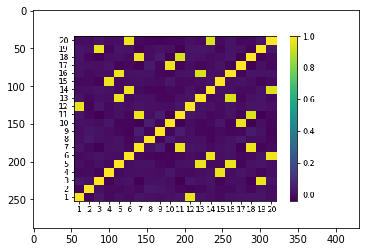

In [113]:
#Para visualizar la imagen:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('HRP3_corr0.png')
imgplot = plt.imshow(img)
plt.show()

## STAGE 1: TREE CLUSTERING 
#### First: Compute Distance Matrix
The distance is defined as d(i,j) = sqr(1/2*(1-corr(i,j))) which produces the distance between each asset on how they correlates to the portfolio.The lower the distance, the more similar two assets’ correlations with the portfolio are.

In [114]:
#The distance Matrix is define as :
def correlDist(corr): 
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist

In [115]:
dist = correlDist(corr)
dist
#Cuanto menor sea la distancia --> Mayor correlación entre ellas.

1         2         3         4         5         6         7   \
1   0.000000  0.714854  0.697465  0.711706  0.704959  0.709362  0.700688   
2   0.714854  0.000000  0.703531  0.710104  0.710635  0.706384  0.710723   
3   0.697465  0.703531  0.000000  0.716250  0.705637  0.702196  0.717943   
4   0.711706  0.710104  0.716250  0.000000  0.710600  0.707073  0.705036   
5   0.704959  0.710635  0.705637  0.710600  0.000000  0.707955  0.703227   
6   0.709362  0.706384  0.702196  0.707073  0.707955  0.000000  0.710706   
7   0.700688  0.710723  0.717943  0.705036  0.703227  0.710706  0.000000   
8   0.706090  0.696188  0.705242  0.706919  0.704444  0.713634  0.705919   
9   0.707092  0.699792  0.703745  0.707906  0.712780  0.717151  0.691686   
10  0.703331  0.705797  0.707548  0.699781  0.715521  0.715077  0.718600   
11  0.699684  0.712206  0.719796  0.708966  0.704905  0.712246  0.122790   
12  0.126059  0.716867  0.699686  0.710743  0.703729  0.707364  0.701089   
13  0.703166  0.712269  0.705677  0.707042  0.122882  0.709752  0.703784   
14  0.706501  0.705681  0.701249  0.704129  0.709183  0.123577  0.710352   
15  0.710765  0.711556  0.716338  0.120926  0.710141  0.707302  0.705966   
16  0.704121  0.710816  0.706687  0.708243  0.125448  0.704265  0.702059   
17  0.703074  0.705268  0.706643  0.700978  0.715269  0.712741  0.718130   
18  0.701478  0.712190  0.717792  0.706695  0.703570  0.709294  0.122941   
19  0.700469  0.703321  0.123022  0.715420  0.701391  0.702018  0.716825   
20  0.708382  0.707821  0.700705  0.708658  0.706215  0.117563  0.711812   

          8         9         10        11        12        13        14  \
1   0.706090  0.707092  0.703331  0.699684  0.126059  0.703166  0.706501   
2   0.696188  0.699792  0.705797  0.712206  0.716867  0.712269  0.705681   
3   0.705242  0.703745  0.707548  0.719796  0.699686  0.705677  0.701249   
4   0.706919  0.707906  0.699781  0.708966  0.710743  0.707042  0.704129   
5   0.704444  0.712780  0.715521  0.704905  0.703729  0.122882  0.709183   
6   0.713634  0.717151  0.715077  0.712246  0.707364  0.709752  0.123577   
7   0.705919  0.691686  0.718600  0.122790  0.701089  0.703784  0.710352   
8   0.000000  0.715535  0.692922  0.706689  0.705254  0.704891  0.715469   
9   0.715535  0.000000  0.714063  0.690534  0.706142  0.713333  0.715644   
10  0.692922  0.714063  0.000000  0.717838  0.708181  0.714444  0.711263   
11  0.706689  0.690534  0.717838  0.000000  0.699693  0.705133  0.712344   
12  0.705254  0.706142  0.708181  0.699693  0.000000  0.702127  0.704471   
13  0.704891  0.713333  0.714444  0.705133  0.702127  0.000000  0.710416   
14  0.715469  0.715644  0.711263  0.712344  0.704471  0.710416  0.000000   
15  0.708167  0.709063  0.699988  0.709909  0.710074  0.706951  0.703747   
16  0.704198  0.713449  0.714693  0.703885  0.703139  0.174878  0.705967   
17  0.694814  0.712213  0.122516  0.717341  0.708682  0.714166  0.710192   
18  0.707917  0.695611  0.720304  0.169117  0.701582  0.704085  0.709153   
19  0.708415  0.704017  0.706947  0.719106  0.701700  0.701272  0.702084   
20  0.714756  0.717295  0.714481  0.712961  0.705769  0.708972  0.169572   

          15        16        17        18        19        20  
1   0.710765  0.704121  0.703074  0.701478  0.700469  0.708382  
2   0.711556  0.710816  0.705268  0.712190  0.703321  0.707821  
3   0.716338  0.706687  0.706643  0.717792  0.123022  0.700705  
4   0.120926  0.708243  0.700978  0.706695  0.715420  0.708658  
5   0.710141  0.125448  0.715269  0.703570  0.701391  0.706215  
6   0.707302  0.704265  0.712741  0.709294  0.702018  0.117563  
7   0.705966  0.702059  0.718130  0.122941  0.716825  0.711812  
8   0.708167  0.704198  0.694814  0.707917  0.708415  0.714756  
9   0.709063  0.713449  0.712213  0.695611  0.704017  0.717295  
10  0.699988  0.714693  0.122516  0.720304  0.706947  0.714481  
11  0.709909  0.703885  0.717341  0.169117  0.719106  0.712961  
12  0.710074  0.703139  0.708682  0.

### Cluster Generation
#### Second: Compute the Euclidean Distance between any two column-vectors.
Secondly, we compute the Euclidean distance between the column-vectors of the distance matrix.
This measures the similarity between two asset on how they correlates to the portfolio.
#### Third,Foutrh, Fifth,Sixth: Cluster Generation
Provided the matrix of similarities between each assets, we proceed to the clustering step to group securities into a hierarchy of clusters.

During each iteration, we pick a set of two most similar securities based on the distance matrix generated from the previous step, group them together as a cluster, and replace this cluster with a generalizing branch. In this implementation, the generalizaing branch is created using the nearest point algorithm. For branch "u" consists of security "i" and "j", the similarty with all remaining securities in the portfolio is calculated as:

        D,u=min{D,i,D,j}

At the end of the clustering step, we have a Nby4 matrix where N stands for the number of clusters. The first two elements consist of branch index (can by both a security or a generalizing branch). The third element is the similarity/distance between the two branches, and the last element indicates the number of securities in the cluster.

In [116]:
import scipy.cluster.hierarchy as sch,random
link=sch.linkage(dist,method='single', metric='euclidean')
link

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


array([[ 3.        , 14.        ,  0.17105233,  2.        ],
       [ 5.        , 19.        ,  0.17259789,  2.        ],
       [ 9.        , 16.        ,  0.17334622,  2.        ],
       [ 2.        , 18.        ,  0.17422504,  2.        ],
       [ 0.        , 11.        ,  0.17851829,  2.        ],
       [ 6.        , 10.        ,  0.17986218,  2.        ],
       [17.        , 25.        ,  0.18003438,  3.        ],
       [ 4.        , 12.        ,  0.18080503,  2.        ],
       [13.        , 21.        ,  0.18253395,  3.        ],
       [15.        , 27.        ,  0.18502824,  3.        ],
       [ 1.        ,  7.        ,  0.98516218,  2.        ],
       [ 8.        , 30.        ,  0.99071676,  3.        ],
       [22.        , 31.        ,  1.13526396,  5.        ],
       [23.        , 32.        ,  1.15214694,  7.        ],
       [24.        , 33.        ,  1.15438354,  9.        ],
       [20.        , 34.        ,  1.15981242, 11.        ],
       [26.        , 35.

Esta función que engloba los pasos de:

    -2. Calcular la distancia euclidea entre dos columnas-vector de la matriz de distancias.
    -3. Agrupando conjuntamente los pares de columnas, quedandonos con el argumento mínimo de cada una de las filas del conjunto.
    -4. "Linkage criterion", definimos la distancia entre el nuevo cluster formado en el paso anterior y "the single item (unclustered) " --> Nearest Point Algorithm.
    -5. Actualizamos la matriz, añadiendo el nuevo cluster y eliminamos "the clustered colums and rows" pertenecientes a u[cluster].
    -6. Aplicamos este proceso de forma recursiva hasta añadir N-1 clusters a la matriz anterior.
    --> Definimos la "linkage matrix"

## STAGE 2: QUASI-DIAGONALIZATION

Provided the clusterization from the last step, we want tp re-organize the covariance matrix so the indexing follows clusters. In order to achive this, we need to first “flatten the clusters” based on the Nby4 matrix generated from the last step. 

We start with the last cluster generated and trace back to its components based on the first two element in the cluster matrix. If a component is a generalizing branch, the function calls itself recursively to trace back the components of the generalizing brach, until the index of a security is returned.

With the cluster based security index generated.Function re-arranges the covariance matrix based on the new index into a quasi-diagonoal covariance matrix. In this way, “similar” securities are group together for the weight allocation step. To re-iterate, the HRP approach first divides securities into clusters and then allocates weightings based on each clusters’ risk level.


In [117]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

In [118]:
getQuasiDiag(link)

[13, 5, 19, 15, 4, 12, 17, 6, 10, 3, 14, 0, 11, 2, 18, 9, 16, 8, 1, 7]

In [119]:
#Almacenamos los indices ordenados:
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels
sortIx

[14, 6, 20, 16, 5, 13, 18, 7, 11, 4, 15, 1, 12, 3, 19, 10, 17, 9, 2, 8]

In [120]:
df0=corr.loc[sortIx,sortIx] # reorder
df0

14        6         20        16        5         13        18  \
14  1.000000  0.969457  0.942490  0.003222 -0.005882 -0.009381 -0.005797   
6   0.969457  1.000000  0.972358  0.008021 -0.002400 -0.007496 -0.006195   
20  0.942490  0.972358  1.000000  0.011074  0.002521 -0.005283 -0.009758   
16  0.003222  0.008021  0.011074  1.000000  0.968525  0.938835  0.016225   
5  -0.005882 -0.002400  0.002521  0.968525  1.000000  0.969800  0.009978   
13 -0.009381 -0.007496 -0.005283  0.938835  0.969800  1.000000  0.008529   
18 -0.005797 -0.006195 -0.009758  0.016225  0.009978  0.008529  1.000000   
7  -0.009200 -0.010206 -0.013353  0.014226  0.010944  0.009377  0.969771   
11 -0.014868 -0.014590 -0.016626  0.009091  0.006218  0.005576  0.942799   
4   0.008406  0.000097 -0.004392 -0.003215 -0.009906  0.000182  0.001163   
15  0.009481 -0.000551 -0.008705 -0.001140 -0.008599  0.000442 -0.000475   
1   0.001711 -0.006390 -0.003611  0.008428  0.006064  0.011116  0.015858   
12  0.007442 -0.000727  0.003780  0.011190  0.009532  0.014034  0.015567   
3   0.016499  0.013842  0.018026  0.001188  0.004153  0.004039 -0.030450   
19  0.014156  0.014342  0.019718  0.013646  0.016102  0.016435 -0.027962   
10 -0.011789 -0.022671 -0.020967 -0.021572 -0.023941 -0.020859 -0.037676   
17 -0.008745 -0.015998 -0.013994 -0.022012 -0.023220 -0.020067 -0.034823   
9  -0.024293 -0.028612 -0.029024 -0.018020 -0.016110 -0.017687  0.032249   
2   0.004029  0.002043 -0.002021 -0.010518 -0.010005 -0.014654 -0.014430   
8  -0.023791 -0.018547 -0.021751  0.008212  0.007518  0.006257 -0.002292   

          7         11        4         15        1         12        3   \
14 -0.009200 -0.014868  0.008406  0.009481  0.001711  0.007442  0.016499   
6  -0.010206 -0.014590  0.000097 -0.000551 -0.006390 -0.000727  0.013842   
20 -0.013353 -0.016626 -0.004392 -0.008705 -0.003611  0.003780  0.018026   
16  0.014226  0.009091 -0.003215 -0.001140  0.008428  0.011190  0.001188   
5   0.010944  0.006218 -0.009906 -0.008599  0.006064  0.009532  0.004153   
13  0.009377  0.005576  0.000182  0.000442  0.011116  0.014034  0.004039   
18  0.969771  0.942799  0.001163 -0.000475  0.015858  0.015567 -0.030450   
7   1.000000  0.969845  0.005849  0.003223  0.018074  0.016948 -0.030884   
11  0.969845  1.000000 -0.005267 -0.007941  0.020884  0.020860 -0.036214   
4   0.005849 -0.005267  1.000000  0.970754 -0.013052 -0.010311 -0.026029   
15  0.003223 -0.007941  0.970754  1.000000 -0.010374 -0.008409 -0.026281   
1   0.018074  0.020884 -0.013052 -0.010374  1.000000  0.968218  0.027085   
12  0.016948  0.020860 -0.010311 -0.008409  0.968218  1.000000  0.020878   
3  -0.030884 -0.036214 -0.026029 -0.026281  0.027085  0.020878  1.000000   
19 -0.027675 -0.034226 -0.023653 -0.025087  0.018686  0.015234  0.969731   
10 -0.032773 -0.030582  0.020612  0.020034  0.010652 -0.003041 -0.001248   
17 -0.031422 -0.029157  0.017259  0.014886  0.011374 -0.004460  0.001310   
9   0.043141  0.046326 -0.002261 -0.005540  0.000041  0.002726  0.009487   
2  -0.010253 -0.014474 -0.008495 -0.012625 -0.022033 -0.027795  0.010087   
8   0.003357  0.001181  0.000531 -0.003002  0.002875  0.005232  0.005269   

          19        10        17        9         2         8   
14  0.014156 -0.011789 -0.008745 -0.024293  0.004029 -0.023791  
6   0.014342 -0.022671 -0.015998 -0.028612  0.002043 -0.018547  
20  0.019718 -0.020967 -0.013994 -0.029024 -0.002021 -0.021751  
16  0.013646 -0.021572 -0.022012 -0.018020 -0.010518  0.008212  
5   0.016102 -0.023941 -0.023220 -0.016110 -0.010005  0.007518  
13  0.016435 -0.020859 -0.020067 -0.017687 -0.014654  0.006257  
18 -0.027962 -0.037676 -0.034823  0.032249 -0.014430 -0.002292  
7  -0.027675 -0.032773 -0.031422  0.043141 -0.010253  0.003357  
11 -0.034226 -0.030582 -0.029157  0.046326 -0.014474  0.001181  
4  -0.023653  0.020612  0.017259 -0.002261 -0.008495  0.000531  
15 -0.025087  0.020034  0.014886 -0.005540 -0.012625 -0.003002  
1   0.018686  0.010652  0.011374  0.

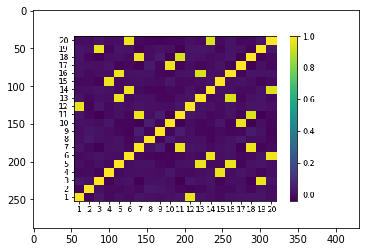

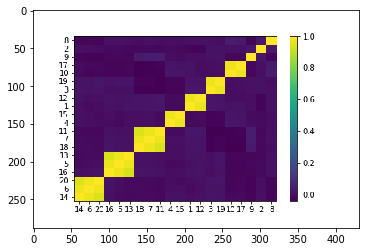

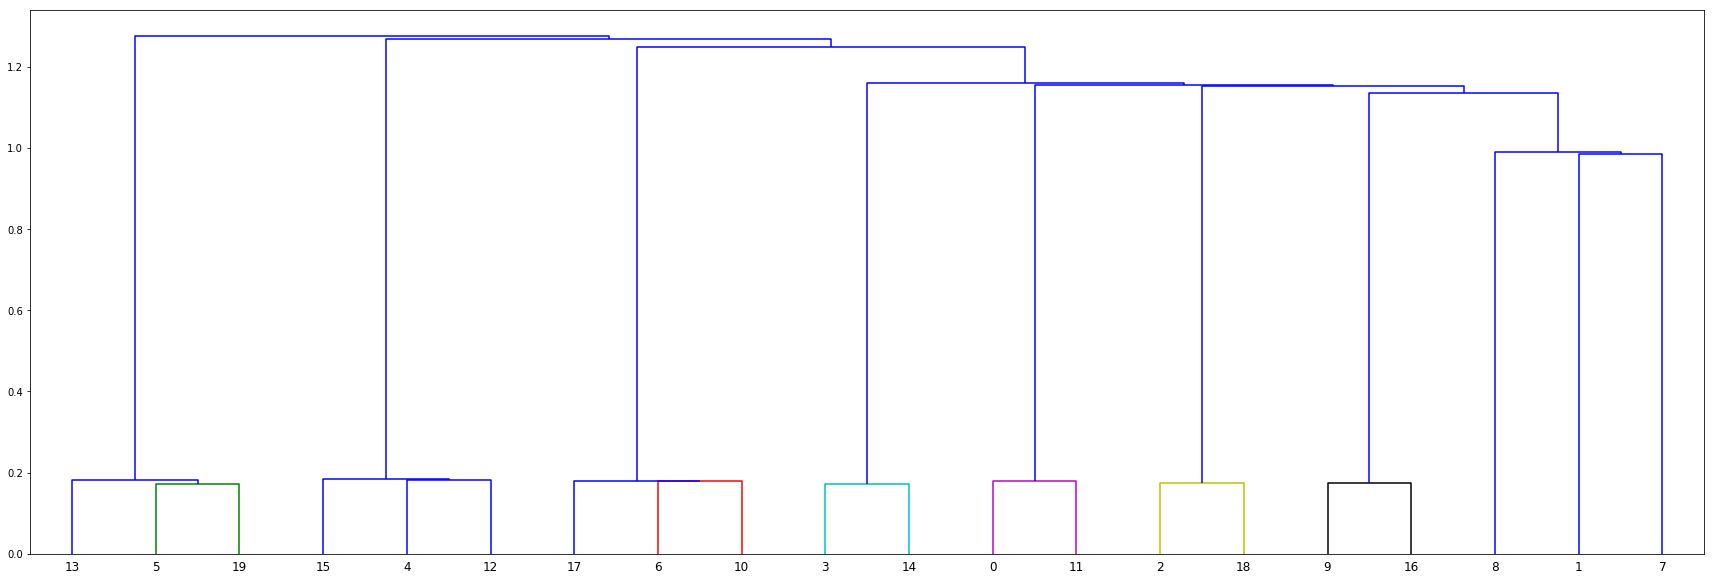

In [121]:
#HeatMap de la de correlaciones ordenadas.
import matplotlib.pyplot as mpl
imgplot0 = mpl.imshow(mpimg.imread('HRP3_corr0.png'))
mpl.show()
plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
imgplot1 = mpl.imshow(mpimg.imread('HRP3_corr1.png'))
mpl.show()
plt.figure(figsize=(30, 10), facecolor='w')
dendrogram(link, color_threshold = 0.18)
plt.show()

## STAGE 3: RECURSIVE BISECTION


In [122]:
cov = x.cov()
cov

1         2         3         4         5         6         7   \
1   0.983936 -0.021719  0.026799 -0.013186  0.006036 -0.006320  0.017698   
2  -0.021719  0.987543  0.009999 -0.008598 -0.009975  0.002024 -0.010058   
3   0.026799  0.009999  0.995031 -0.026443  0.004157  0.013768 -0.030411   
4  -0.013186 -0.008598 -0.026443  1.037277 -0.010122  0.000098  0.005881   
5   0.006036 -0.009975  0.004157 -0.010122  1.006653 -0.002401  0.010840   
6  -0.006320  0.002024  0.013768  0.000098 -0.002401  0.994300 -0.010046   
7   0.017698 -0.010058 -0.030411  0.005881  0.010840 -0.010046  0.974479   
8   0.002807  0.029972  0.005173  0.000533  0.007424 -0.018202  0.003261   
9   0.000041  0.020310  0.009397 -0.002287 -0.016050 -0.028329  0.042288   
10  0.010680  0.003719 -0.001258  0.021221 -0.024281 -0.022851 -0.032704   
11  0.021054 -0.014619 -0.036715 -0.005452  0.006341 -0.014786  0.973055   
12  0.982379 -0.028253  0.021302 -0.010742  0.009782 -0.000741  0.017113   
13  0.011464 -0.015140  0.004188  0.000193  1.011637 -0.007772  0.009624   
14  0.001748  0.004124  0.016950  0.008817 -0.006079  0.995624 -0.009353   
15 -0.010691 -0.013035 -0.027237  1.027192 -0.008964 -0.000571  0.003306   
16  0.008671 -0.010842  0.001229 -0.003396  1.007929  0.008296  0.014566   
17  0.011882  0.005435  0.001376  0.018513 -0.024536 -0.016801 -0.032668   
18  0.015975 -0.014563 -0.030847  0.001203  0.010167 -0.006273  0.972210   
19  0.018880  0.010811  0.985289 -0.024537  0.016456  0.014567 -0.027827   
20 -0.003727 -0.002090  0.018709 -0.004655  0.002632  1.008818 -0.013715   

          8         9         10        11        12        13        14  \
1   0.002807  0.000041  0.010680  0.021054  0.982379  0.011464  0.001748   
2   0.029972  0.020310  0.003719 -0.014619 -0.028253 -0.015140  0.004124   
3   0.005173  0.009397 -0.001258 -0.036715  0.021302  0.004188  0.016950   
4   0.000533 -0.002287  0.021221 -0.005452 -0.010742  0.000193  0.008817   
5   0.007424 -0.016050 -0.024281  0.006341  0.009782  1.011637 -0.006079   
6  -0.018202 -0.028329 -0.022851 -0.014786 -0.000741 -0.007772  0.995624   
7   0.003261  0.042288 -0.032704  0.973055  0.017113  0.009624 -0.009353   
8   0.968627 -0.023435  0.039515  0.001182  0.005267  0.006402 -0.024115   
9  -0.023435  0.985982 -0.019846  0.046753  0.002768 -0.018260 -0.024845   
10  0.039515 -0.019846  1.021852 -0.031420 -0.003144 -0.021923 -0.012274   
11  0.001182  0.046753 -0.031420  1.032992  0.021687  0.005892 -0.015563   
12  0.005267  0.002768 -0.003144  0.021687  1.046272  0.014925  0.007840   
13  0.006402 -0.018260 -0.021923  0.005892  0.014925  1.080950 -0.010045   
14 -0.024115 -0.024845 -0.012274 -0.015563  0.007840 -0.010045  1.060758   
15 -0.003069 -0.005715  0.021041 -0.008385 -0.008937  0.000477  0.010145   
16  0.008383 -0.018560 -0.022619  0.009583  0.011872  1.012444  0.003441   
17  0.035727 -0.015157  1.032661 -0.031210 -0.004805 -0.021973 -0.009485   
18 -0.002291  0.032521 -0.038678  0.973133  0.016170  0.009005 -0.006063   
19 -0.003713  0.008820  0.000465 -0.035432  0.015872  0.017405  0.014851   
20 -0.022274 -0.029986 -0.022053 -0.017582  0.004023 -0.005715  1.009981   

          15        16        17        18        19        20  
1  -0.010691  0.008671  0.011882  0.015975  0.018880 -0.003727  
2  -0.013035 -0.010842  0.005435 -0.014563  0.010811 -0.002090  
3  -0.027237  0.001229  0.001376 -0.030847  0.985289  0.018709  
4   1.027192 -0.003396  0.018513  0.001203 -0.024537 -0.004655  
5  -0.008964  1.007929 -0.024536  0.010167  0.016456  0.002632  
6  -0.000571  0.008296 -0.016801 -0.006273  0.014567  1.008818  
7   0.003306  0.014566 -0.032668  0.972210 -0.027827 -0.013715  
8  -0.003069  0.008383  0.035727 -0.002291 -0.003713 -0.022274  
9  -0.005715 -0.018560 -0.015157  0.032521  0.008820 -0.029986  
10  0.021041 -0.022619  1.032661 -0.038678  0.000465 -0.022053  
11 -0.008385  0.009583 -0.031210  0.973133 -0.035432 -0.017582  
12 -0.008937  0.011872 -0.004805  0.

In [123]:
#Función Recursive Bisection:
def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[int(j):int(k)] for i in cItems for j,k in ((0,len(i)/2), \
                                                   (len(i)/2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            print(cItems0)
            cItems1=cItems[i+1] # cluster 2
            print(cItems1)
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            print(alpha)
            w[cItems0]*=alpha # weight 1 
            w[cItems1]*=1-alpha # weight 2
    return w 

#Función para calcular la varianza por cada cluster:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

#Función para calcular la inversa de la varianza del portfolio:   
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp
    

In [124]:
#4) Capital allocation
hrp=getRecBipart(cov,sortIx)
print(hrp)

[14, 6, 20, 16, 5, 13, 18, 7, 11, 4]
[15, 1, 12, 3, 19, 10, 17, 9, 2, 8]
0.3662182460847554
[14, 6, 20, 16, 5]
[13, 18, 7, 11, 4]
0.45869248612353186
[15, 1, 12, 3, 19]
[10, 17, 9, 2, 8]
0.4351977754582168
[14, 6]
[20, 16, 5]
0.3663059248915502
[13, 18]
[7, 11, 4]
0.5122862213156127
[15, 1]
[12, 3, 19]
0.5295066280516649
[10, 17]
[9, 2, 8]
0.24113203469168676
[14]
[6]
0.4838305868960272
[20]
[16, 5]
0.4859667140748337
[13]
[18]
0.4882611888213151
[7]
[11, 4]
0.3456877096860802
[15]
[1]
0.4768618747711528
[12]
[3, 19]
0.4887785960516472
[10]
[17]
0.5204898500599284
[9]
[2, 8]
0.3382510700335579
[16]
[5]
0.4833826322022058
[11]
[4]
0.5010348085621789
[3]
[19]
0.5104472312446329
[2]
[8]
0.4951649726087919
14    0.029771
6     0.031761
20    0.051731
16    0.026450
5     0.028268
13    0.049585
18    0.051969
7     0.033422
11    0.031696
4     0.031565
15    0.069645
1     0.076404
12    0.063430
3     0.033864
19    0.032478
10    0.044927
17    0.041389
9     0.091884
2     0.089011
8  

### REPRODUCING THE MONTE CARLO EXPERIMENT

The following code implements Monte Carlo experiments on three allocation methods: HRP, CLA and IVP. All libraries are standard except for HRP, which is provided in Appendix A.2, and CLA, which can be found in Bailey and López de Prado [2013]. The subroutine generateData() simulates the correlated data, with two types of random shocks: Common to various investments and specific to a single investment. There are two shocks of each type, one positive and one negative. The variables for the experiments are set as arguments of hrpMC(). They were chosen arbitrarily, and the user can experiment with alternative combinations.

In [6]:
import scipy.cluster.hierarchy as sch
import random
import numpy as np
import pandas as pd
#from HRP import correlDist,getIVP,getQuasiDiag,getRecBipart